In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
data = pd.read_excel('co-op dataset.xlsx')

# Display the dataframe
print(data)

          ID WEEK_END_DT  TOTAL_DISPENSED  FLAVORED_DISPENSED
0    743BD6E  2022-07-10         278418.0         60878.00000
1    1CD19D3  2022-07-10          28045.0         10517.00004
2    D3635AD  2022-07-10          23631.0         16203.99998
3    A74A256  2022-07-10              NaN                 NaN
4    BB7EA2A  2022-07-10         132980.0         79995.00001
..       ...         ...              ...                 ...
350  FBCE7D2  2023-10-01          18096.0          6573.00001
351  1CD19D3  2023-10-01              NaN                 NaN
352  D3635AD  2023-10-01         143329.0         45258.00001
353  A74A256  2023-10-01          80881.0         29208.99999
354  BB7EA2A  2023-10-01         179271.0         52692.99997

[355 rows x 4 columns]


In [3]:
# Check for missing values
print(data.isnull().sum())

ID                     0
WEEK_END_DT            0
TOTAL_DISPENSED       43
FLAVORED_DISPENSED    43
dtype: int64


In [13]:
# Fill missing values with the mean of each machine's dispense data
data['TOTAL_DISPENSED'] = data.groupby('ID')['TOTAL_DISPENSED'].transform(lambda x: x.fillna(x.mean()))
data['FLAVORED_DISPENSED'] = data.groupby('ID')['FLAVORED_DISPENSED'].transform(lambda x: x.fillna(x.mean()))

# Check for any remaining missing values
missing_values = data.isnull().sum()
print("Missing Values after filling:\n", missing_values)


Missing Values after filling:
 ID                    0
WEEK_END_DT           0
TOTAL_DISPENSED       0
FLAVORED_DISPENSED    0
dtype: int64


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  355 non-null    object        
 1   WEEK_END_DT         355 non-null    datetime64[ns]
 2   TOTAL_DISPENSED     355 non-null    float64       
 3   FLAVORED_DISPENSED  355 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 11.2+ KB
None

Summary Statistics of Dispensed Quantities:
       TOTAL_DISPENSED  FLAVORED_DISPENSED
count       355.000000          355.000000
mean     122684.797183        46616.628168
std      108058.230459        40351.991981
min         417.000000            0.000000
25%       21944.000000         6366.000000
50%       99550.000000        38266.000090
75%      187922.000000        78182.000000
max      530939.000000       159114.999970


/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

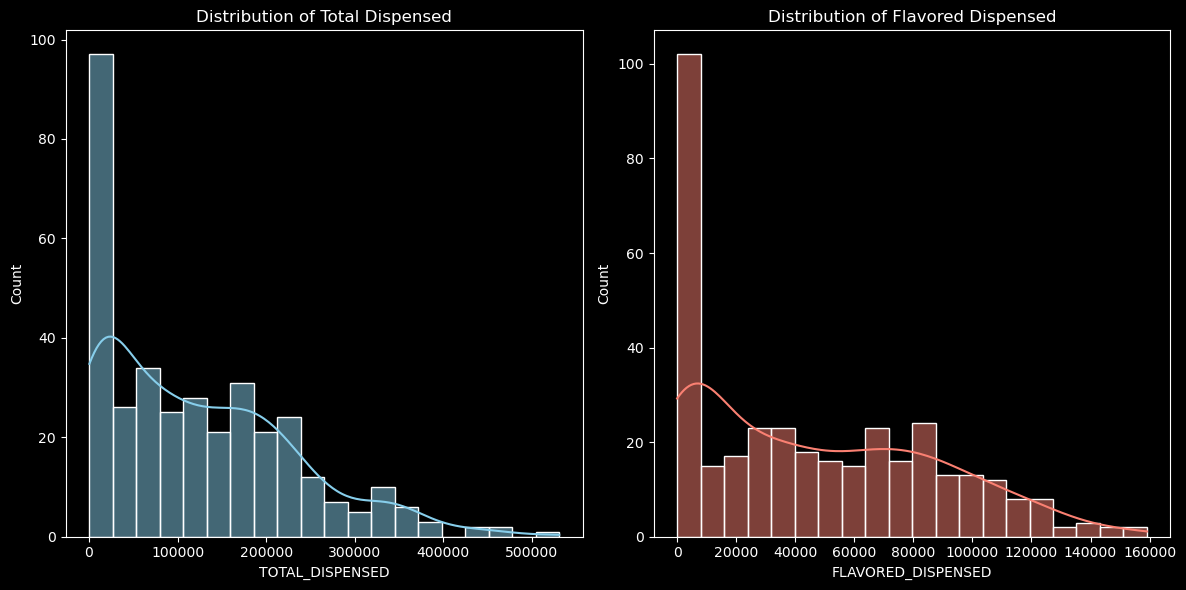

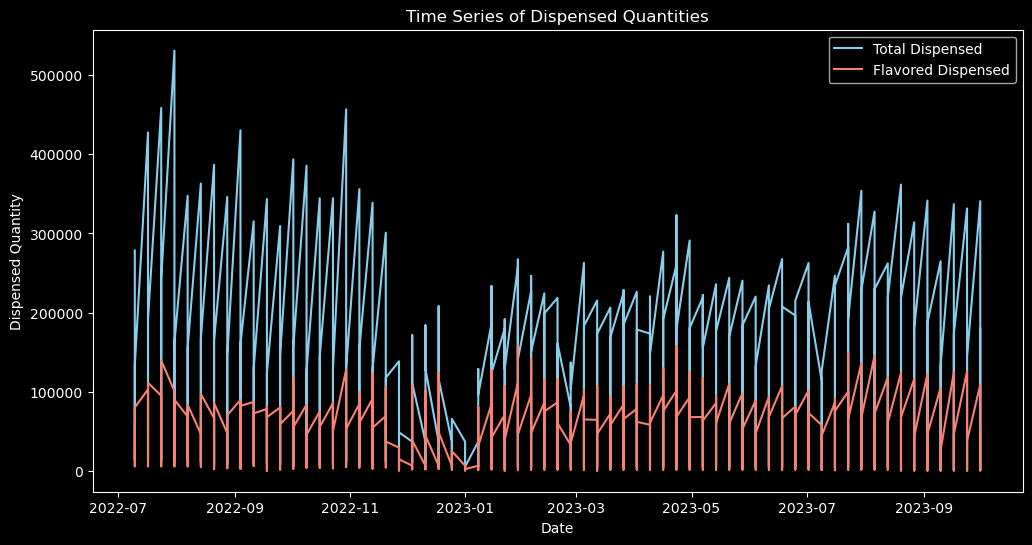

In [27]:

import seaborn as sns
# Display basic information about the data
print("Data Info:")
print(data.info())

# Display summary statistics of dispensed quantities
print("\nSummary Statistics of Dispensed Quantities:")
print(data[['TOTAL_DISPENSED', 'FLAVORED_DISPENSED']].describe())

# Plot histograms of dispensed quantities
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['TOTAL_DISPENSED'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Total Dispensed')

plt.subplot(1, 2, 2)
sns.histplot(data['FLAVORED_DISPENSED'], bins=20, kde=True, color='salmon')
plt.title('Distribution of Flavored Dispensed')

plt.tight_layout()
plt.show()

# Plot time series of dispensed quantities
plt.figure(figsize=(12, 6))
plt.plot(data['WEEK_END_DT'], data['TOTAL_DISPENSED'], label='Total Dispensed', color='skyblue')
plt.plot(data['WEEK_END_DT'], data['FLAVORED_DISPENSED'], label='Flavored Dispensed', color='salmon')
plt.xlabel('Date')
plt.ylabel('Dispensed Quantity')
plt.title('Time Series of Dispensed Quantities')
plt.legend()
plt.show()

<Figure size 800x600 with 0 Axes>

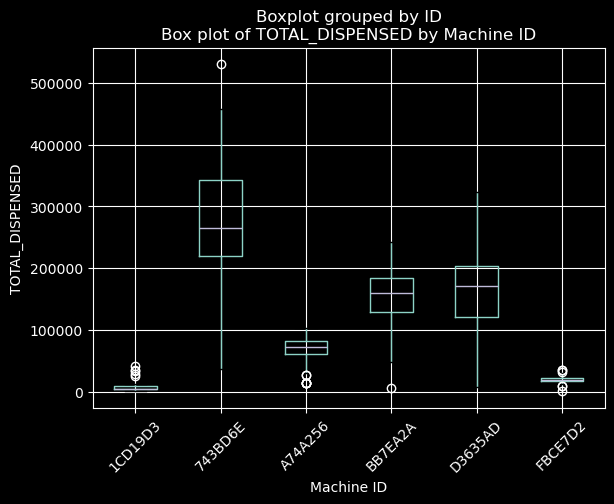

<Figure size 800x600 with 0 Axes>

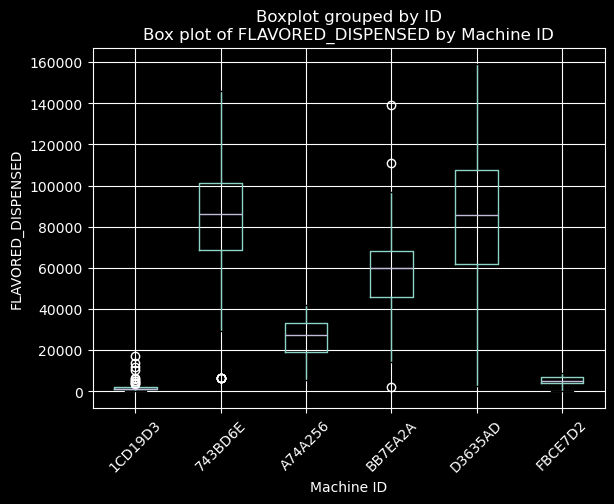

In [15]:
# Box plot for TOTAL_DISPENSED
plt.figure(figsize=(8, 6))
data.boxplot(column='TOTAL_DISPENSED', by='ID')
plt.title('Box plot of TOTAL_DISPENSED by Machine ID')
plt.ylabel('TOTAL_DISPENSED')
plt.xlabel('Machine ID')
plt.xticks(rotation=45)
plt.show()

# Box plot for FLAVORED_DISPENSED
plt.figure(figsize=(8, 6))
data.boxplot(column='FLAVORED_DISPENSED', by='ID')
plt.title('Box plot of FLAVORED_DISPENSED by Machine ID')
plt.ylabel('FLAVORED_DISPENSED')
plt.xlabel('Machine ID')
plt.xticks(rotation=45)
plt.show()

In [28]:
# 1. Temporal Features
data['week_day'] = pd.to_datetime(data['WEEK_END_DT']).dt.dayofweek
data['month'] = pd.to_datetime(data['WEEK_END_DT']).dt.month
data['quarter'] = pd.to_datetime(data['WEEK_END_DT']).dt.quarter
data['year'] = pd.to_datetime(data['WEEK_END_DT']).dt.year

# 2. Lagged Variables
data['total_dispensed_lag1'] = data['TOTAL_DISPENSED'].shift(1)
data['flavored_dispensed_lag1'] = data['FLAVORED_DISPENSED'].shift(1)

# 3. Moving Averages
data['total_dispensed_ma3'] = data['TOTAL_DISPENSED'].rolling(window=3).mean()
data['flavored_dispensed_ma3'] = data['FLAVORED_DISPENSED'].rolling(window=3).mean()


In [29]:
# Drop rows with NaN values resulting from lagged variables and moving averages
data.dropna(inplace=True)

In [16]:
# Convert WEEK_END_DT to datetime format
data['WEEK_END_DT'] = pd.to_datetime(data['WEEK_END_DT'])

# Split data into training and testing sets
train_data = data[data['WEEK_END_DT'] <= '2023-06-30']
test_data = data[(data['WEEK_END_DT'] >= '2023-07-01') & (data['WEEK_END_DT'] <= '2023-09-30')]

# Display the shapes of training and testing sets
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)


Training data shape: (271, 4)
Testing data shape: (78, 4)


In [17]:
# Perform one-hot encoding for the 'ID' column
train_data = pd.get_dummies(train_data, columns=['ID'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['ID'], drop_first=True)

# Display the updated shapes of training and testing sets
print("Updated training data shape:", train_data.shape)
print("Updated testing data shape:", test_data.shape)


Updated training data shape: (271, 8)
Updated testing data shape: (78, 8)


In [18]:
# Extract temporal features from 'WEEK_END_DT' column
def extract_temporal_features(df):
    df['week_day'] = df['WEEK_END_DT'].dt.dayofweek  # Day of the week (0 = Monday, 6 = Sunday)
    df['month'] = df['WEEK_END_DT'].dt.month  # Month (1-12)
    df['quarter'] = df['WEEK_END_DT'].dt.quarter  # Quarter of the year (1-4)
    return df

# Apply the function to both training and testing sets
train_data = extract_temporal_features(train_data)
test_data = extract_temporal_features(test_data)

# Display the updated shapes of training and testing sets
print("Updated training data shape:", train_data.shape)
print("Updated testing data shape:", test_data.shape)

Updated training data shape: (271, 11)
Updated testing data shape: (78, 11)


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into features (X) and target variable (y)
X = data[['week_day', 'month', 'quarter', 'year', 
          'total_dispensed_lag1', 'flavored_dispensed_lag1', 
          'total_dispensed_ma3', 'flavored_dispensed_ma3']]
y = data['TOTAL_DISPENSED']  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared Score:", r2)


Linear Regression Model Evaluation:
Mean Squared Error (MSE): 7637538887.529767
R-squared Score: 0.3919673331222232


/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: Future

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima  # for automatic parameter selection
import warnings

# Ignore harmless warnings
warnings.filterwarnings("ignore")

# Step 1: Identify Seasonality (Weekly Seasonality)
seasonality_period = 7  # weekly seasonality

# Step 2: Stationarity Check (if necessary)
# We'll assume the data is already stationary for simplicity

# Step 3: Parameter Selection (Use auto_arima for automatic parameter selection)
model = auto_arima(y_train, seasonal=True, m=seasonality_period)

# Get the selected SARIMA parameters
p, d, q = model.order
P, D, Q, s = model.seasonal_order

# Step 4: Fit the SARIMA Model
sarima_model = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_fit = sarima_model.fit()

# Step 5: Forecasting
forecast_horizon = len(y_test)
sarima_forecast = sarima_fit.forecast(steps=forecast_horizon)

# Evaluate the SARIMA model
mse = mean_squared_error(y_test, sarima_forecast)
r2 = r2_score(y_test, sarima_forecast)

print("SARIMA Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared Score:", r2)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34045D+01    |proj g|=  5.07308D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   1.021D-06   1.333D+01
  F =   13.326170484675462     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA Model Evaluation:
Mean Squared Error (MSE): 29791031668.027996
R-squared Score: -1.3716960006222645


 This problem is unconstrained.


In [33]:
# Separate features and target variable for testing data
X_test = test_data.drop(columns=['WEEK_END_DT', 'TOTAL_DISPENSED', 'FLAVORED_DISPENSED'])
y_test = test_data['TOTAL_DISPENSED']  # We're predicting total dispensed water

# Predict on testing data
y_test_pred = model.predict(X_test)

# Evaluate the model on testing data
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)

print("Testing RMSE:", test_rmse)
print("Testing R^2 Score:", test_r2)


TypeError: n_periods must be an int

In [25]:
# Define the weeks in months July to November for forecasting
forecast_weeks = pd.date_range(start='2023-07-01', end='2023-11-30', freq='W-SUN')

# Create a dataframe to store the forecasted dispensed quantities
forecast_data = pd.DataFrame(index=forecast_weeks)

# Extract temporal features for forecasting data
forecast_data['week_day'] = forecast_data.index.dayofweek
forecast_data['month'] = forecast_data.index.month
forecast_data['quarter'] = forecast_data.index.quarter

# Initialize dummy columns for machine IDs
for machine_id in train_data.drop(columns=['WEEK_END_DT', 'TOTAL_DISPENSED', 'FLAVORED_DISPENSED']).columns:
    forecast_data[machine_id] = 0  # Initialize all dummy columns to zero

# Set the dummy column corresponding to each machine ID to one
for machine_id in forecast_data.columns.intersection(train_data.drop(columns=['WEEK_END_DT', 'TOTAL_DISPENSED', 'FLAVORED_DISPENSED']).columns):
    forecast_data[machine_id] = 1

# Reorder columns of forecast data to match the order of features used during training
forecast_data = forecast_data[train_data.drop(columns=['WEEK_END_DT', 'TOTAL_DISPENSED', 'FLAVORED_DISPENSED']).columns]

# Predict dispensed quantities for the forecasting period
forecast_values = model.predict(forecast_data)

# Add the forecasted values to the dataframe
forecast_data['TOTAL_DISPENSED'] = forecast_values

# Display the forecasted dispensed quantities
print("Forecasted Dispensed Quantities for July to November 2023:")
print(forecast_data['TOTAL_DISPENSED'])


Forecasted Dispensed Quantities for July to November 2023:
2023-07-02    632903.597798
2023-07-09    632903.597798
2023-07-16    632903.597798
2023-07-23    632903.597798
2023-07-30    632903.597798
2023-08-06    632903.597798
2023-08-13    632903.597798
2023-08-20    632903.597798
2023-08-27    632903.597798
2023-09-03    632903.597798
2023-09-10    632903.597798
2023-09-17    632903.597798
2023-09-24    632903.597798
2023-10-01    632903.597798
2023-10-08    632903.597798
2023-10-15    632903.597798
2023-10-22    632903.597798
2023-10-29    632903.597798
2023-11-05    632903.597798
2023-11-12    632903.597798
2023-11-19    632903.597798
2023-11-26    632903.597798
Freq: W-SUN, Name: TOTAL_DISPENSED, dtype: float64


/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [5]:
# Function to fill missing values based on the median of each machine
def fill_missing_values(group):
    group['total_dispensed'].fillna(group['total_dispensed'].median(), inplace=True)
    group['flavored_dispensed'].fillna(group['flavored_dispensed'].median(), inplace=True)
    return group

# Apply the function to each machine group
data = data.groupby('machine_id').apply(fill_missing_values).reset_index(drop=True)

# Check for any remaining missing values
print(data.isnull().sum())


machine_id            0
week_end_date         0
total_dispensed       0
flavored_dispensed    0
dtype: int64


In [6]:
# Add week number and month as features
data['week_number'] = data['week_end_date'].dt.isocalendar().week
data['month'] = data['week_end_date'].dt.month

# Remove potential outliers (values that are significantly higher or lower than the rest)
def remove_outliers(group):
    Q1 = group['total_dispensed'].quantile(0.25)
    Q3 = group['total_dispensed'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['total_dispensed'] >= lower_bound) & (group['total_dispensed'] <= upper_bound)]

data = data.groupby('machine_id').apply(remove_outliers).reset_index(drop=True)

# Display the first few rows of the data with new features
print(data.head())


  machine_id week_end_date  total_dispensed  flavored_dispensed  week_number  \
0    1CD19D3    2022-10-09           8293.0              3673.0           40   
1    1CD19D3    2023-02-05           8293.0              2318.0            5   
2    1CD19D3    2023-02-12           8293.0              2318.0            6   
3    1CD19D3    2023-02-19           8293.0              2318.0            7   
4    1CD19D3    2023-02-26           8293.0              2318.0            8   

   month  
0     10  
1      2  
2      2  
3      2  
4      2  


In [7]:
# Train-Test Split
train_data = data[data['week_end_date'] <= '2023-06-30']
test_data = data[(data['week_end_date'] > '2023-06-30') & (data['week_end_date'] <= '2023-09-30')]

In [11]:
# Forecasting function using SARIMA
def sarima_forecast(train, test, order=(1,1,1), seasonal_order=(1,1,1,52)):
    forecasts = []
    actuals = []
    for machine_id in train['machine_id'].unique():
        machine_train = train[train['machine_id'] == machine_id]
        machine_test = test[test['machine_id'] == machine_id]
        
        model = SARIMAX(machine_train['total_dispensed'],
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        results = model.fit(disp=False)
        
        forecast = results.get_forecast(steps=len(machine_test))
        forecast_values = forecast.predicted_mean.values
        actual_values = machine_test['total_dispensed'].values
        
        forecasts.extend(forecast_values)
        actuals.extend(actual_values)
        
        plt.figure(figsize=(10, 6))
        plt.plot(machine_train['week_end_date'], machine_train['total_dispensed'], label='Train')
        plt.plot(machine_test['week_end_date'], machine_test['total_dispensed'], label='Test')
        plt.plot(machine_test['week_end_date'], forecast_values, label='Forecast')
        plt.title(f'Machine {machine_id} Usage Forecast')
        plt.legend()
        plt.show()
    
    return actuals, forecasts

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


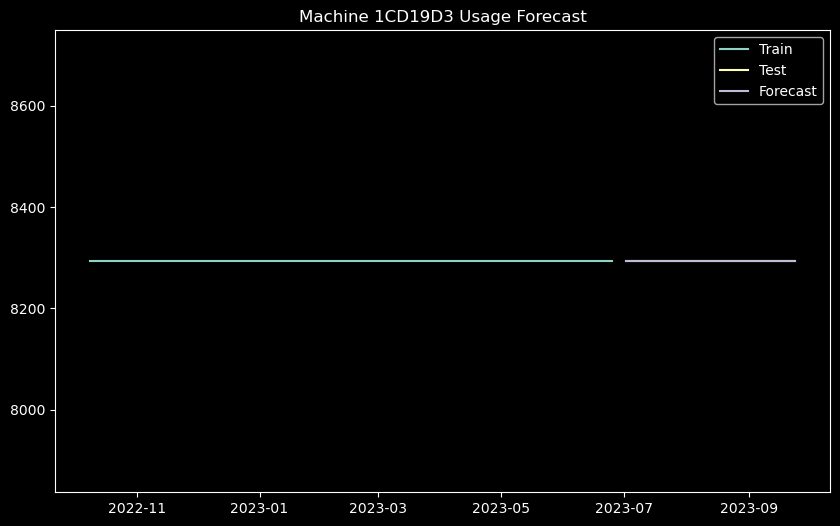

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal AR

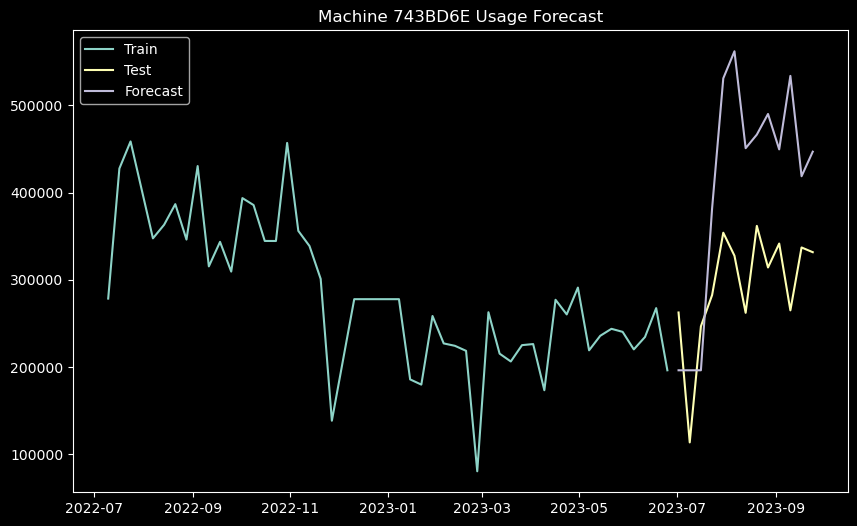

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal AR

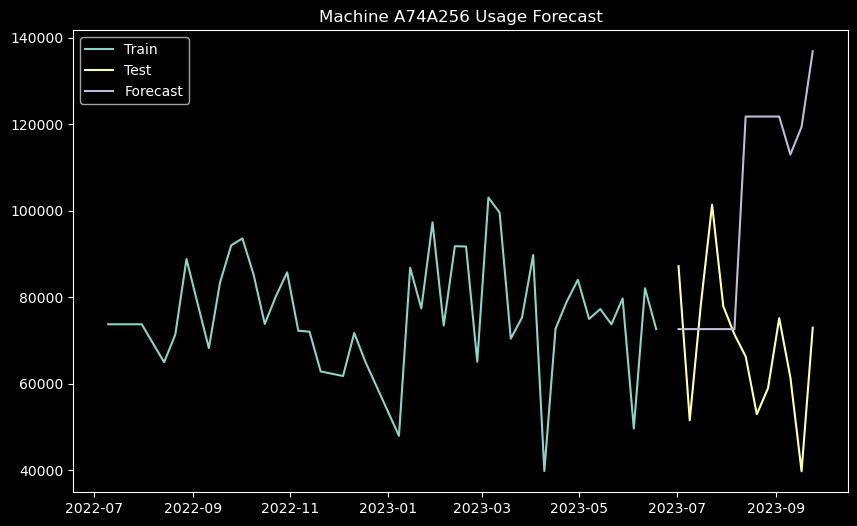

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal AR

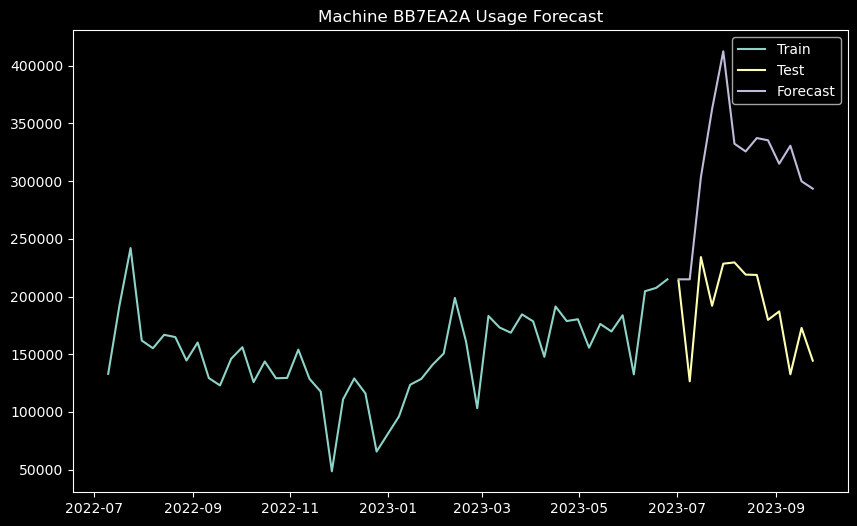

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal AR

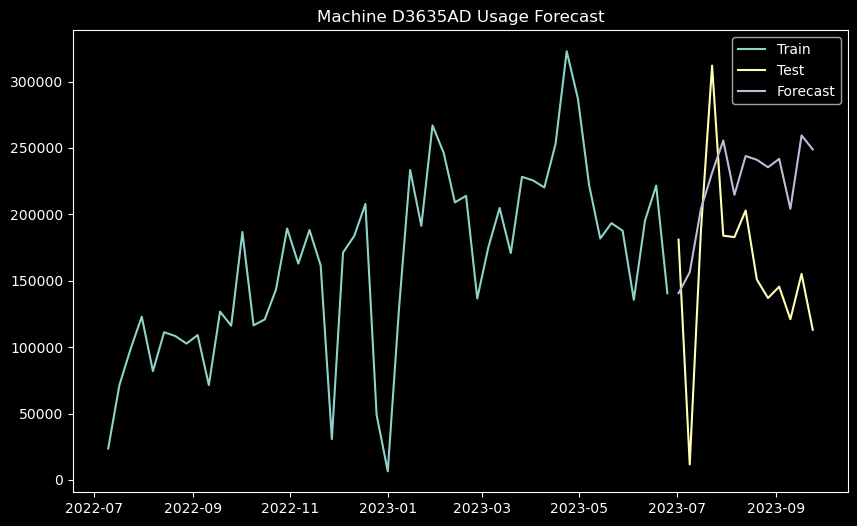

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal AR

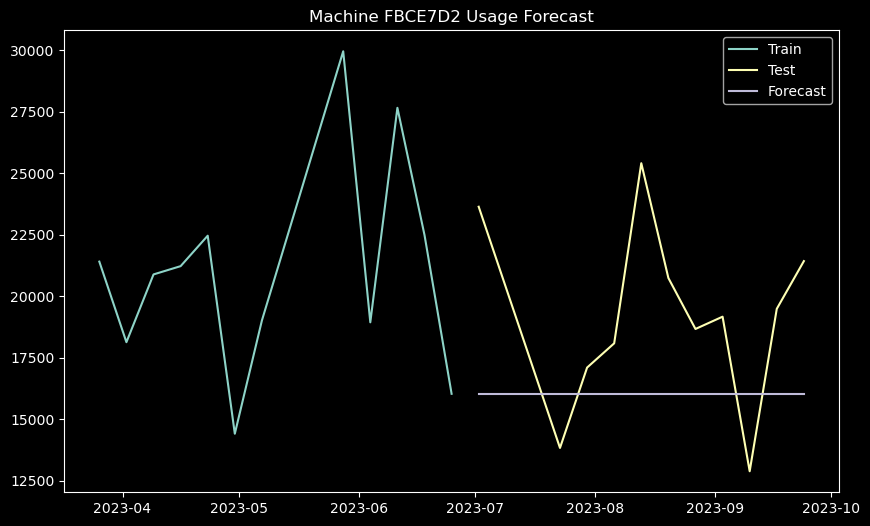

Mean Absolute Error: 65849.99999999993
Root Mean Squared Error: 93144.08762113305


In [9]:

# Run forecasting and calculate accuracy
actuals, forecasts = sarima_forecast(train_data, test_data)
mae = mean_absolute_error(actuals, forecasts)
rmse = np.sqrt(mean_squared_error(actuals, forecasts))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')